In [110]:
import pandas as pd
import numpy as np
np.random.seed(0)
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests as smm

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки. 

In [75]:
data = pd.read_csv('./ab_browser_test.csv', ',')
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [76]:
data.shape

(566134, 6)

In [77]:
data_exp = data.loc[data['slot'] == 'exp']
data_ctl = data.loc[data['slot'] == 'control']

In [78]:
diff_procent = (data_exp.n_clicks.sum() - data_ctl.n_clicks.sum()) * 100. / data_ctl.n_clicks.sum()
print round(diff_procent, 3)

1.614


Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения. 

In [79]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

def odds(data):
    p = data.sum() / data.shape[0]
    return p / (1 - p)

In [80]:

samples = 500

exp_click_mean, ctl_click_mean = np.empty(samples), np.empty(samples)
exp_click_med, ctl_click_med = np.empty(samples), np.empty(samples)

ctl_click_var = np.empty(samples)

exp_data = get_bootstrap_samples(data_exp.n_clicks.values, samples)
ctl_data = get_bootstrap_samples(data_ctl.n_clicks.values, samples)

print exp_data

for i in range(samples):
    exp_click_mean[i], ctl_click_mean[i] = exp_data[i].mean(), ctl_data[i].mean() 
    exp_click_med[i], ctl_click_med[i] = np.median(exp_data[i]), np.median(ctl_data[i])
    ctl_click_var[i] = ctl_data[i].var()

delta_mean = map(lambda x: x[0] - x[1], zip(exp_click_mean, ctl_click_mean))
delta_median = map(lambda x: x[0] - x[1], zip(exp_click_med, ctl_click_med))

delta_mean_bnd = stat_intervals(delta_mean, 0.05)
delta_median_bnd = stat_intervals(delta_median, 0.05)

print('Conf. int. delta mean: [%.4f, %.4f]' % (delta_mean_bnd[0], delta_mean_bnd[1]))
print('Conf. int. delta median: [%d, %d]' % (delta_median_bnd[0], delta_median_bnd[1]))
print('legend: diff = exp - control')

[[ 2 45 25 ... 11  2  1]
 [ 7  3  1 ...  1 16  5]
 [ 1 25  6 ...  0  7  2]
 ...
 [ 5 24 48 ...  7 14 17]
 [98 26  6 ...  6 13 78]
 [ 1  1  0 ...  0  6 10]]
Conf. int. delta mean: [0.1996, 0.4050]
Conf. int. delta median: [1, 1]
legend: diff = exp - control


Нормально ли распределены выборки?

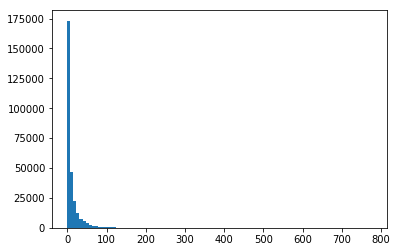

In [81]:
plt.hist(data_exp.n_clicks, bins=100)
plt.show()

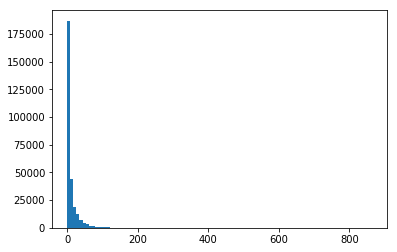

In [82]:
plt.hist(data_ctl.n_clicks, bins=100)
plt.show()

t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид X¯−μS2/n√, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

X¯ — среднее значение в выборке — было распределено нормально (μ,σ2n)
nσ2S2 — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c n−1 степенями свободы χ2(n−1)
Простое доказательство необходимости и достаточности этого требования можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

Получите из данных n_boot_samples псевдовыборок.
По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды

Text(0.5,1,'Probability plot for means')

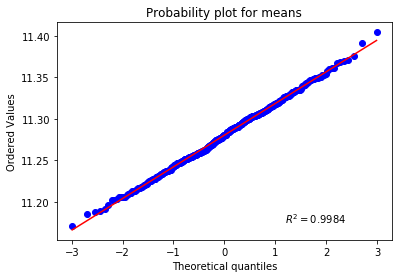

In [83]:
#probability plot for means
stats.probplot(ctl_click_mean, plot=plt, rvalue=True)
plt.title('Probability plot for means')

Text(0.5,1,'Probability plot for variances')

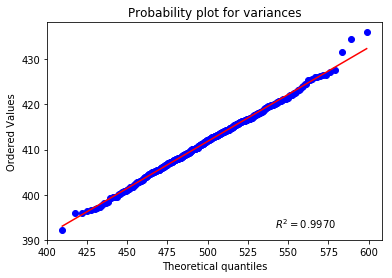

In [84]:
#probability plot for variances
stats.probplot(ctl_click_var, plot=plt, dist='chi2', sparams=(ctl_click_mean.shape[0]-1), rvalue=True)
plt.title('Probability plot for variances')


In [100]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [102]:
browsers_clicks_exp = data_exp.groupby(['browser', 'userID']).sum().loc[:,'n_clicks']
browsers_clicks_ctl = data_ctl.groupby(['browser', 'userID']).sum().loc[:,'n_clicks']

browsers_clicks_exp.head()
browsers_clicks_ctl.head()

browser      userID
Browser #14  15        2
             39        0
             56        4
             81        2
             88        2
Name: n_clicks, dtype: int64

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с 
α
=
0
.
0
5
α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [112]:
#Unique browsers
browsers = np.unique(data.browser)
print('Unique browsers numbers: ' + str(browsers))
print('')

print('Mann-Whitney rank test without multipletest')
mw_p = np.empty(browsers.shape[0])
for i, br in enumerate(browsers):
    print('Browser #{0}: '.format(br))
    _, mw_p[i] = stats.mannwhitneyu(browsers_clicks_exp.loc[br, :], browsers_clicks_ctl.loc[br, :], alternative='two-sided')
    print('p-value = %.4f' % mw_p[i])

print('')
print('Mann-Whitney rank test with multipletest')
_, mw_p_corr, _, _ = smm(mw_p, alpha = 0.05, method = 'holm')
for i, br in enumerate(browsers):
    print('Browser #{0}: '.format(br))
    print('p-value = %.4f' % mw_p_corr[i])

Unique browsers numbers: ['Browser #14' 'Browser #17' 'Browser #2' 'Browser #20' 'Browser #22'
 'Browser #4']

Mann-Whitney rank test without multipletest
Browser #Browser #14: 
p-value = 0.0000
Browser #Browser #17: 
p-value = 0.0748
Browser #Browser #2: 
p-value = 0.0545
Browser #Browser #20: 
p-value = 0.9073
Browser #Browser #22: 
p-value = 0.5148
Browser #Browser #4: 
p-value = 0.8152

Mann-Whitney rank test with multipletest
Browser #Browser #14: 
p-value = 0.0000
Browser #Browser #17: 
p-value = 0.2992
Browser #Browser #2: 
p-value = 0.2724
Browser #Browser #20: 
p-value = 1.0000
Browser #Browser #22: 
p-value = 1.0000
Browser #Browser #4: 
p-value = 1.0000


Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения.

In [114]:
browsers_nonclk_q_exp = data_exp.groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_exp    = data_exp.groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_exp = browsers_nonclk_q_exp / browsers_clk_q_exp

browsers_nonclk_q_ctrl = data_ctl.groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_ctrl    = data_ctl.groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_ctrl = browsers_nonclk_q_ctrl / browsers_clk_q_ctrl

print('Control / experimental groups')
for br in browsers:
    print('Browser #{0}'.format(br))
    print(browsers_nonclk_q_prop_ctrl.loc[browsers_nonclk_q_prop_ctrl.index == br].values),
    print('/'),
    print(browsers_nonclk_q_prop_exp.loc[browsers_nonclk_q_prop_ctrl.index == br].values)

Control / experimental groups
Browser #Browser #14
[0.57590411] / [0.43755617]
Browser #Browser #17
[0.36299367] / [0.36937413]
Browser #Browser #2
[0.45962747] / [0.44982747]
Browser #Browser #20
[0.40540485] / [0.38977376]
Browser #Browser #22
[0.40593977] / [0.39853947]
Browser #Browser #4
[0.4697093] / [0.45142942]
